# Econ 323 Final Project
# The Geographic Distribution of Political Ideologies and Polarization
### By: Jaycee Tolentino

In this notebook, I analyze trends in political polarization of United States congressmembers over time and compare these trends by region. I explore electoral competition in congressional elections as a force in moderating politicians political behavior.

The classic conception of the median voter theorem (Downs, 1957) suggests that politician's incentives to capture votes forces them to move their policy positions towards that preferred by the "median voter" of the electorate on an economic left-right spectrum. However, if incumbent politicians don’t need to worry about losing their seat, there is less of an incentive to drive their policies towards the “median voter” (Alesina, 1988), so they can be more radical.

After processing the data, I represent the trends and geographic distributions of polarization and electoral competition in several line plots and cloropleth maps. At the end, I include interactive code for mapping the idological distribuition of congressmemebers.

## Sections
    1.) Import Packages, Load, and Clean Data
        1.1) State Names and Census Divisions
        1.2) Polarization Data
        1.3) Election Data
        1.4) Congressional District Shapefiles
        1.5) Merge all Datasets
    2.) Trends in Political Polarization and Electoral Competition
    3.) Regression Analysis
    4.) Geographic Distributions
    5.) Interactive Ideology Map
    6.) Conclusion

## 1.) Import Packages, Load, and Clean Data

In [218]:
# Import packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import zipfile
import io
from sklearn import linear_model

# For Interactive map
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.models import (GeoJSONDataSource, LinearColorMapper, ColorBar, 
                          HoverTool, WheelZoomTool, BoxZoomTool, PanTool, ResetTool)
from bokeh.palettes import brewer
from bokeh.layouts import row, column
import json

### 1.1) State names and Census divisions

These features will facilitate a comparison of trends across regions: Midwest, Northeast, South, West.

In [219]:
# State names and codes for merging

states_url = "https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv"
state_names = pd.read_csv(states_url).rename(columns = {"State Code": "state_code"})
state_names.columns = [x.lower() for x in state_names.columns]

### 1.2) Polarization Data

[*Voteview.com*](https://voteview.com/data) aggregates information about all roll call votes of United States congressmembers and generates a two-dimensional score (**NOMINATE**) for each politician in an idological spectrum. This analysis uses the first dimension measure, interpreted as **economic liberalism-conservatism**. This score ranges from $ -1 $ to $ 1 $, with lower values indicating liberal-leaning politicians and higher values indicating conservative-leaning politicians. Naturally, moderate politicians are closer to $ 0 $.

To measure political polarization, I take the absolute value of the NOMINATE score. This gives equal weight to radical liberals and radical conservatives. Higher values of this measure denote more radical politicians. 

Sometimes this data records two representatives to a single district during the same term. This happens when the seat becomes vacated (most often in cases of resignation). When this happens I take a weighted average of their NOMINATE scores, using the number of votes as the weight. This gives more weight to more active representative. These cases measure the average polarization of the districts rather than of any specific representative.

When there is one representative:
$$
Polarized = NOMINATE
$$

When there are two representatives:
$$
Polarized = \frac{NOMINATE_1 * Votes_1 + NOMINATE_2 * Votes_2}{Votes_1 + Votes_2}\
$$


(For more information on NOMINATE scores, see: https://en.wikipedia.org/wiki/NOMINATE_(scaling_method))

In [220]:
### Congressmember ideology data

voteview_url = "http://voteview.com/static/data/out/members/Hall_members.csv"
voteview = pd.read_csv(voteview_url, index_col = 0).reset_index() # Read in data

house = (voteview.loc[(voteview["chamber"] == "House") & (voteview["congress"] >= 95)] # Only examine congress after 1976
         .rename(columns = {"district_code": "district", 
                            "state_abbrev": "state_code", 
                            "nominate_number_of_votes": "nominate_votes"})
         .merge(state_names)
        )

# Indentifier for unique congress-district
district_ID = ["congress", "state", "district"]

print(house.info())
house.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9741 entries, 0 to 9740
Data columns (total 25 columns):
congress                         9741 non-null int64
chamber                          9741 non-null object
icpsr                            9741 non-null int64
state_icpsr                      9741 non-null int64
district                         9741 non-null int64
state_code                       9741 non-null object
party_code                       9741 non-null int64
occupancy                        8852 non-null float64
last_means                       8852 non-null float64
bioname                          9741 non-null object
bioguide_id                      9740 non-null object
born                             9740 non-null float64
died                             1868 non-null float64
nominate_dim1                    9739 non-null float64
nominate_dim2                    9739 non-null float64
nominate_log_likelihood          9691 non-null float64
nominate_geo_mean_probabili

,congress,chamber,icpsr,state_icpsr,district,state_code,party_code,occupancy,last_means,bioname,...,nominate_log_likelihood,nominate_geo_mean_probability,nominate_votes,nominate_number_of_errors,conditional,nokken_poole_dim1,nokken_poole_dim2,state,region,division
0,95,House,10706,41,6,AL,200,0.0,1.0,"BUCHANAN, John Hall, Jr.",...,-511.71160,0.638,1140.0,238.0,NaN,0.059,-0.296,Alabama,South,East South Central
1,95,House,10717,41,2,AL,200,0.0,1.0,"DICKINSON, William Louis",...,-342.51259,0.724,1062.0,149.0,NaN,0.289,0.207,Alabama,South,East South Central
2,95,House,10721,41,1,AL,200,0.0,1.0,"EDWARDS, William Jackson (Jack)",...,-380.81636,0.719,1156.0,169.0,NaN,0.114,0.149,Alabama,South,East South Central
3,95,House,11000,41,4,AL,100,0.0,1.0,"BEVILL, Tom",...,-394.06496,0.714,1169.0,177.0,NaN,-0.193,0.885,Alabama,South,East South Central
4,95,House,11037,41,3,AL,100,0.0,1.0,"NICHOLS, William Flynt",...,-322.68400,0.753,1138.0,130.0,NaN,-0.028,0.687,Alabama,South,East South Central


##### Note: "At-large" districts 
At-large districts are those that cover the whole state and aren't necessarily numbered. Throughout the data I will code these as $ 1 $.

In [221]:
# Let's see how this data codes at-large districts

dist = house.sort_values(by = "district").district.unique()  # Unique values of district codes, sorted

print(f"The 3 lowest district values are {[dist[v] for v in range(0,3)]}, \
and the 3 highest district values are {[dist[v] for v in range(len(dist) - 3,len(dist))]}")

# Vermont always an at-large district since 1930, see how this is coded for an example

Vermont_district = house.loc[house["state_code"] == "VT"].district.unique()
print(f"Ex/ At-large district Vermont coded as {(Vermont_district)}")

The 3 lowest district values are [1, 2, 3], and the 3 highest district values are [51, 52, 53]
Ex/ At-large district Vermont coded as [1]


##### Note: Missing NOMINATE scores
Jack Swigert won the general election but died before starting his first term in office. Shelley Sekula Gibbs only served for two months (November 13, 2006 – January 3, 2007) to fill in after the resignation of Tom DeLay. I drop these observations and only use information from the other congressmembers who served the district in the same term.

In [222]:
# Let's see why some observations are missing a NOMINATE score

# Count how many congressmembers are missing a NOMINATE score
nominate_missing_count = (house["nominate_dim1"].isnull().sum())
print(f"The NOMINATE score is missing for {nominate_missing_count} congressmembers")

def missing_value_districts(df, var, ID = district_ID):
    '''
    Returns each representative in a district where one representative's
    value is missing in the data
    '''
    missings = df.loc[df[var].isnull() == True]
    missings_districts = missings.loc[ :, (ID)] 
    districts = df.merge(missings_districts, on = ID, how = "inner") 
    return districts

display(missing_value_districts(house, "nominate_dim1")[["congress", "icpsr", "district", "state", 
                                                         "bioname", "nominate_dim1", "nominate_votes"]]
       )

# Drop congressmembers with missing NOMINATE scores

house = house.dropna(subset=['nominate_dim1'])

The NOMINATE score is missing for 2 congressmembers


,congress,icpsr,district,state,bioname,nominate_dim1,nominate_votes
0,98,15058,6,Colorado,"SCHAEFER, Daniel",0.479,736.0
1,98,15067,6,Colorado,"SWIGERT, John Leonard, Jr. (Jack)",NaN,NaN
2,109,15094,22,Texas,"DeLAY, Thomas Dale",0.593,624.0
3,109,20541,22,Texas,"SEKULA GIBBS, Shelley",NaN,NaN


##### Note: Missing NOMINATE vote counts
If there are multiple representatives who serve the term I use the NOMINATE score of the representative with the non-missing vote count. If there is only one representative with a missing vote count, I use his/her NOMINATE score with full weight.

In [223]:
# Record how many representatives served a district in each term
    # Note: original "occupancy" variable not reliable because of missing values
    
occupants = house.groupby(district_ID).size().reset_index().rename(columns = {0: "occupants"})
house2 = house.merge(occupants, on = district_ID, how = "left")

# Two reps: give rep with missing votes 0 weight
house2.loc[(house2["nominate_votes"].isnull() == True) & (house2["occupants"] == 2), "nominate_votes"] = 0

# One rep: give rep with missing votes full weight
house2.loc[(house2["nominate_votes"].isnull() == True) & (house2["occupants"] == 1), "nominate_votes"] = 1

In [224]:
# Calculate the polarization measure

def score_x_votes(df):
    return df["nominate_dim1"] * df["nominate_votes"]

def weighted_score(df):
    total_score = df["nominate_dim1_x_votes"].sum()
    total_votes = df["nominate_votes"].sum()
    weighted_nominate = total_score / total_votes
    return weighted_nominate

house2["nominate_dim1_x_votes"] = house2.apply(score_x_votes, axis = 1)

ideology = (house2.groupby(district_ID) # Group by the district-congress
            .apply(weighted_score) # Take weigted average NOMINATE score in the district-congress
            .reset_index().rename(columns = {0: "nominate"}) # Create new DataFrame
            .merge(state_names, on = "state", how = "left") # Re-merge with region names
           )

ideology["polarized"] = abs(ideology["nominate"]) # Take absolute value of weighted NOMINATE score => Polarized

ideology.head()

,congress,state,district,nominate,state_code,region,division,polarized
0,95,Alabama,1,0.177,AL,South,East South Central,0.177
1,95,Alabama,2,0.398,AL,South,East South Central,0.398
2,95,Alabama,3,-0.042,AL,South,East South Central,0.042
3,95,Alabama,4,-0.213,AL,South,East South Central,0.213
4,95,Alabama,5,-0.175,AL,South,East South Central,0.175


### 1.3) Election Data

The [*MIT Election Data and Science Lab*](https://electionlab.mit.edu/data) has complete district-level voting data for congressional elections since 1976. I use this data to provide a measure of electoral competition in the district. 

I take the highest vote count in each election as the winning vote count, and I divide this by the number of total votes to measure the winning vote share (**WinShare**). Higher values of winning vote share indicate the election was easier to win, while lower values indicate a more split vote and higher electoral competition.

In [225]:
# Load elections data

elections_url = "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/IG0UN2/Y1WLPQ"
elections = pd.read_table(elections_url, index_col = 0).reset_index().rename(columns = {"state_po": "state_code"}) # Read in data

elections["candidatevotes"] = (elections["candidatevotes"]
                               .str.replace(",","").astype(int) # Remove commas from vote counts and conver to numeric
                              )

elections = elections.loc[elections["year"] <= 2016] # Keep elections from 1976 to 2016

print(elections.info())
elections.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28277 entries, 0 to 28276
Data columns (total 19 columns):
year              28277 non-null int64
state             28277 non-null object
state_code        28277 non-null object
state_fips        28277 non-null int64
state_cen         28277 non-null int64
state_ic          28277 non-null int64
office            28277 non-null object
district          28277 non-null int64
stage             28247 non-null object
runoff            20980 non-null object
special           28277 non-null bool
candidate         26306 non-null object
party             25005 non-null object
writein           28277 non-null bool
mode              28277 non-null object
candidatevotes    28277 non-null int32
totalvotes        28277 non-null float64
unofficial        28277 non-null bool
version           28277 non-null int64
dtypes: bool(3), float64(1), int32(1), int64(6), object(8)
memory usage: 3.6+ MB
None


,year,state,state_code,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170.0,False,20171005
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170.0,False,20171005
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170.0,False,20171005
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362.0,False,20171005
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362.0,False,20171005


In [226]:
# Let's see how this data codes at-large districts

dist = elections.sort_values(by = "district").district.unique() # Unique values of district codes, sorted

print(f"The 3 lowest district values are {[dist[v] for v in range(0, 3)]}, \
and the 3 highest district values are {[dist[v] for v in range(len(dist) - 3, len(dist))]}")

dist_0 = elections.loc[elections["district"] == 0].state.unique()
print(f"Districts coded as 0 are in states: {dist_0}")

# Recode at-large districts as 1
elections.loc[(elections["district"] == 0), "district"] = 1

The 3 lowest district values are [0, 1, 2], and the 3 highest district values are [51, 52, 53]
Districts coded as 0 are in states: ['Alaska' 'Delaware' 'Nevada' 'North Dakota' 'Vermont' 'Wyoming'
 'South Dakota' 'Montana']


##### Note: Odd Elections

In very rare cases, elections were ran with an open primary and runoff system. Candidates compete in an open primary, and another election is called between the top candidates if no one surpasses a certain vote threshold in the first round. I focus on general elections, so I drop these odd elections.

In [227]:
# How many general elections and primaries are included in the data

display(elections.groupby("stage").stage.count())

# How many recorded as runoffs

display(elections.groupby("runoff").runoff.count())

# This analysis only concerns general elections

gen = elections.loc[(elections["stage"] != "pri") & (elections["runoff"] != "True")]

stage
gen    28187
pri       60
Name: stage, dtype: int64

runoff
False    20972
True         8
Name: runoff, dtype: int64

##### Note: Fusion Voting
Some states allow the same candidate to run under several party labels - a practice called "fusion voting". For example, one candidate can run under the banners of the Republican, Conservative, and Libertarian parties in a district, and another can run under the Democrat, Liberal, and Green parties in a district. This happens very often in New York and was more common in the past. In these cases I sum up the total votes for each candidate across all the parties they run in and use this total vote count when I calculate the winning vote count.

In [228]:
# Combine fusion votes for the same candidate in an election
cand_ID = ["year", "state", "district", "candidate"]

candidate_votes_ID = (gen.groupby(cand_ID)["candidatevotes"].sum() # Group by candidate and sum votes across all parties
                      .reset_index().rename(columns = {"candidatevotes": "votes"}) # Create a DataFrame
                     )

gen = gen.merge(candidate_votes_ID, on = cand_ID, how = "left") # Merge original data with updated vote totals

In [229]:
# Denote the highest vote share as the winner and divide by total votes to obtain winning vote share

# Unique election identifier
el_ID = ["year", "state", "district"]

win_vote = (gen.groupby(el_ID)["votes"].max() # Isolate highest vote count for each election
            .reset_index().rename(columns = {"votes" : "win_vote"})) # Create a DataFrame

total_votes = gen[(el_ID) + ["totalvotes"]].drop_duplicates(el_ID) # Create DataFrame of total votes in each election
votes = win_vote.merge(total_votes, on = el_ID, how = "left") # Merge vote data

# Check for 0 or negative values of votes before dividing
outlier_votes = votes.loc[(votes["totalvotes"] <= 0) | (votes["win_vote"] <= 0)] 
outlier_districts = gen.merge(outlier_votes, on = el_ID, how = "inner")[el_ID + ["candidate", "party"]]

print("This following election(s) recorded votes of 0")
display(outlier_districts)

votes.loc[(votes["totalvotes"] <= 0), "totalvotes"] = 1
votes.loc[(votes["win_vote"] <= 0), "win_vote"] = 1

This following election(s) recorded votes of 0


,year,state,district,candidate,party
0,2016,Florida,24,Frederica S. Wilson,democrat


##### Note: 0 Vote Count

Frederica S. Wilson ran and won unopposed in this election. I recode the votes to facilitate a share measure of $ 1 $.

In [230]:
# Calculate winshare

def win_share(df):
    return df["win_vote"] / df["totalvotes"]

votes["WinShare"] = votes.apply(win_share, axis = 1)

### 1.4) Congressional District Shapefiles
[*United States Congressional District Shapefiles*](http://cdmaps.polisci.ucla.edu/) provides digital boundary definitions for United States congressional districts. I use these to map the measures of polarization and electoral competition to visualize the geographic distribution.

In [231]:
def extract_files(url):
    '''
    Extracts all the files in folders within a zipped folder from a url
    '''
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    files = z.namelist()
    return files

# Specify congressional sessions to use for shapefiles
first_congressmap = 95
last_congressmap = 114

congressmap = (list(range(first_congressmap, last_congressmap + 1)))
congressmap_range = range(0, len(congressmap))


In [232]:
urls = ["http://cdmaps.polisci.ucla.edu/shp/districts" + str(congressmap[c]).zfill(3) + ".zip" for c in congressmap_range]

# This will take quite a while to extract all the shapefiles

files = [sorted(extract_files(url)) for url in urls] # Sort so the .shp file is always listed third

In [233]:
# Extract the shapefiles (.shp) only

shape_data = [gpd.read_file(files[c][2]) for c in congressmap_range] # Create GeoDataFrames

for c in congressmap_range: # Denote the congressional session for each file
    shape_data[c]["congress"] = first_congressmap + c
    
    
# Append shapefiles for each congressional session into one GeoDataFrame
shapes = pd.DataFrame()

for c in congressmap_range:
    shapes = shapes.append(shape_data[c], sort = True)
    
# Use most recent congress map (114th) for the 115th congress
shape_data_115 = shape_data[len(shape_data) - 1]
shape_data_115["congress"] = 115

shapes = (shapes.append(shape_data_115, sort = True)
          .rename(columns = {"STATENAME": "state", "DISTRICT": "district", })
         )

# Update congress list to include 115th congress
congress = congressmap + [115]

In [234]:
# Some of the shapes have null geometries

null = (shapes["geometry"].isnull() == True)
null_states = shapes[null]["state"].unique()
null_congresses = shapes[null]["congress"].unique()

print(f"There are {len(shapes[null]['state'])} null geometries in {null_states}, \
in the following congressional sessions: {null_congresses}")


There are 13 null geometries in ['District Of Columbia'], in the following congressional sessions: [103 104 105 106 107 108 109 110 111 112 113 114 115]


##### Note:  Null Geometries
Null geometries are all in the District of Columbia (DC). These are not problematic because there are no congressional representatives for DC.

In [235]:
# Let's see how this data codes districts

shapes["district"] = pd.to_numeric(shapes['district']) # First convert to numeric
dist_shp = shapes.sort_values(by = "district").district.unique() # Unique values of district codes, sorted

print(f"The 3 lowest district values are {[dist_shp[v] for v in range(0,3)]}, \
and the 3 highest district values are {[dist_shp[v] for v in range(len(dist_shp) - 3,len(dist_shp))]}")

dist_0 = shapes.loc[shapes["district"] == 0]["state"].unique()
dist_98 = shapes.loc[shapes["district"] == 98]["state"].unique()

print(f"Districts coded as 0 are in states: {dist_0}")
print(f"Districts coded as 98 are in states: {dist_98}")

print("Recode at-large districts from 0 to 1")
shapes.loc[(shapes["district"] == 0) & (shapes["state"] != "District Of Columbia"), "district"]= 1

print("Recode DC from 0 to 98")
shapes.loc[(shapes["district"] == 0) & (shapes["state"] == "District Of Columbia"), "district"]= 98

The 3 lowest district values are [0, 1, 2], and the 3 highest district values are [52, 53, 98]
Districts coded as 0 are in states: ['Vermont' 'Delaware' 'Alaska' 'Nevada' 'North Dakota' 'Wyoming'
 'South Dakota' 'District Of Columbia' 'Montana']
Districts coded as 98 are in states: ['District Of Columbia']
Recode at-large districts from 0 to 1
Recode DC from 0 to 98


### 1.5) Merge all Data

Now that all the datasets have been cleaned and ready to line up, it's time to merge them!

In [236]:
# Map election years to congressional districts
years = [1976 + x for x in range(0, (2 * len(congress)), 2)]

cong_year = pd.DataFrame(data = {"year": years, "congress": congress})

In [237]:
# Complete dataset for mapping (Includes geogoraphy for DC for complete map even though there are no representatves there)
datamap_full = (shapes.merge(ideology, on = (district_ID), how = "left") # Merge with ideology data
                      .merge(cong_year, on = "congress", how = "left") # Merge with congress - year translation
                      .merge(votes, on = ["year", "state", "district"], how = "left") # Merge with voting data
               )

# Smaller dataset with only the necessary features
ideology_features = ["nominate", "polarized"]
vote_features = ["win_vote", "totalvotes", "WinShare"]
other_features = district_ID + ["geometry", "region", "division", "year"]
main_columns = ideology_features + vote_features + other_features

datamap = datamap_full[main_columns]

# Data without geography

data = datamap.drop(columns = "geometry").loc[datamap["state"] != "District Of Columbia"]

In [238]:
datamap.head()

,nominate,polarized,win_vote,totalvotes,WinShare,congress,state,district,geometry,region,division,year
0,0.490,0.490,114623.0,209611.0,0.546837,95,California,27,"POLYGON ((-118.56632 34.13771, -118.56564 34.1...",West,Pacific,1976
1,-0.040,0.040,95807.0,96026.0,0.997719,95,Georgia,2,"POLYGON ((-84.62062 32.23305, -84.62074 32.231...",South,South Atlantic,1976
2,-0.339,0.339,106222.0,115962.0,0.916007,95,New York,10,"MULTIPOLYGON (((-73.87101 40.78738, -73.87101 ...",Northeast,Middle Atlantic,1976
3,-0.478,0.478,84770.0,114458.0,0.740621,95,New York,11,"MULTIPOLYGON (((-73.86424 40.59085, -73.86264 ...",Northeast,Middle Atlantic,1976
4,-0.332,0.332,100042.0,127951.0,0.781877,95,New York,37,"MULTIPOLYGON (((-78.90206 42.91276, -78.90256 ...",Northeast,Middle Atlantic,1976


## 2.) Trends in Political Polarization and Electoral Competition

Because my measure of electoral competition is based on the vote share of the winning candidate. Higher values of `WinShare` indicate lower electoral competition and vice versa. 

My hypothesis for this study is that lower levels of electoral competition (higher vote shares for the winner) are correlated with higher levels of polarization. So, I expect to see `polarized` and `WinShare` moving in the same direction over time.

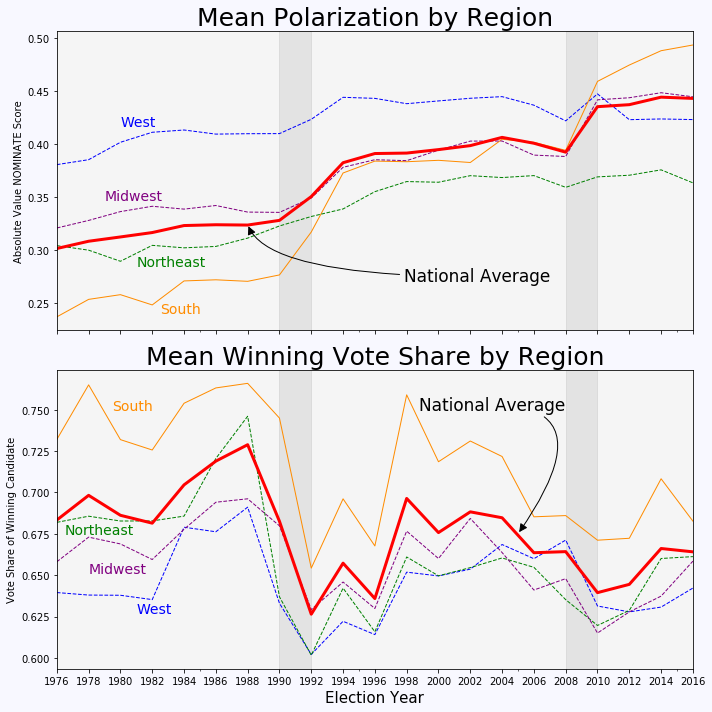

In [239]:
def plot_mean_regions(geog, geog_val, color,
                      df = data, var = "polarized", time = "year", linewidth = 1, linestyle = "solid"):
    '''
    Plots the mean of a variable over a period of time 
    within a specified geographic unit (ex/ regions, states)
    '''
    area = df.loc[df[geog] == geog_val]
    mean_var = area.groupby(time)[var].mean() 
    mean_var_plot = mean_var.plot(linewidth = linewidth, linestyle = linestyle, color = color)
    
    return mean_var_plot

# Create figure
fig, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = True)

# Colors for plotting
colors = ["blue", "darkorange", "green", "purple"]

# First plot - Polarization over time
plt.sca(ax[0])

# Create plots for regions
for reg, color in zip(data["region"].unique(), colors) :
    if reg == "South":
        plot_mean_regions("region", reg, color) # Differentiate the South with a solid line
    else:
        plot_mean_regions("region", reg, color, linestyle = "dashed")
    
# Plot for whole sample
data.groupby("year")["polarized"].mean().plot(color = "red", linewidth = 3)

# Label the plots
ax[0].text(1980, .417, "West", color = colors[0], fontsize = 14)
ax[0].text(1982.5, .24, "South", color = colors[1], fontsize = 14)
ax[0].text(1981, .285, "Northeast", color = colors[2], fontsize = 14)
ax[0].text(1979, .347, "Midwest", color = colors[3], fontsize = 14)

ax[0].annotate(
    "National Average",
    xy=(1988, .324), xycoords="data", xytext=(2007, 0.27),
    color = "black",
    annotation_clip=False,
    horizontalalignment="right",
    fontsize=17,
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=110",
        "color": "black"
    },
)

# Other Plot properties
ax[0].set_title("Mean Polarization by Region", fontsize = 25 )
ax[0].axvspan(1990, 1992, color = "grey", alpha = 0.15 )
ax[0].axvspan(2008, 2010, color = "grey", alpha = 0.15 )
ax[0].set_facecolor("whitesmoke")
ax[0].set_ylabel("Absolute Value NOMINATE Score")


# Second Plot - Winning Vote Share over Time
plt.sca(ax[1])

# Create plots for regions
for reg, color in zip(data["region"].unique(), colors):
    if reg == "South":
        plot_mean_regions("region", reg, color, var = "WinShare") # Differentiate the South with a solid line
    else:
        plot_mean_regions("region", reg, color, var = "WinShare", linestyle = "dashed")
        
# Plot for whole sample     
data.groupby("year")["WinShare"].mean().plot(color = "red", linewidth = 3)

# Label the plots
ax[1].text(1981, .627, "West", color = colors[0], fontsize = 14)
ax[1].text(1979.5, .75, "South", color = colors[1], fontsize = 14)
ax[1].text(1976.5, .675, "Northeast", color = colors[2], fontsize = 14)
ax[1].text(1978, .651, "Midwest", color = colors[3], fontsize = 14)

ax[1].annotate(
    "National Average",
    xy=(2005, .675), xycoords="data", xytext=(2008, 0.75),
    color = "black",
    annotation_clip=False,
    horizontalalignment="right",
    fontsize=17,
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=-125",
        "color": "black"
    },
)

# Other Plot properties
ax[1].set_title("Mean Polarization by Region", fontsize = 25 )
ax[1].axvspan(1990, 1992, color = "grey", alpha = 0.15 )
ax[1].axvspan(2008, 2010, color = "grey", alpha = 0.15 )
ax[1].set_title("Mean Winning Vote Share by Region", fontsize = 25 )
ax[1].set_facecolor("whitesmoke")
ax[1].set_xticks(years)
ax[1].set_xlabel("Election Year", fontsize = 15)
ax[1].set_ylabel("Vote Share of Winning Candidate")

fig.set_facecolor("ghostwhite")

fig.tight_layout()

#### Polarization
   
Polarization has indeed been rising over time in all regions of the United States. The biggest change is in the South, which went from least polarized region in 1976 to the most polarized region in 2016. However, the sharp change in the South's polarization relative to the other regions cannot be explained by any sharp change in electoral competition relative to the other regions.

#### Electoral Competition

Winning vote shares has been fairly volatile over time. Throughout the years, the South has had notably lower levels of electoral competition (high levels of `WinShare`) compared to the other regions. Although the areas have different underlying levels of competition, all regions follow the same trends very closely and experience the same shocks at the same time.

#### Major Shocks

The sharpest rises in electoral competition (falls in WinShare) are accompanied by the sharpest rises in polarization. The first shock occured in 1992 - Bill Clinton's first victory over incumbent president George H.W. Bush. The second shock occured during Barack Obama's first midterm elections which saw the largest swing in congressional seats (63) and the Republicans regaining control in the House. These movements contradict the main hypothesis. However, the sharpest fall in electoral competition in 1998 does not see any change in polarization. 

***There seems to be no regular pattern connecting electoral competition and polarization***

## 3.) Regression Analysis

Next, I model a linear regression between polarization and the winning vote share. I report the coefficients and plot the line over a scatterplot of the data.

$$
Polarized = \beta_0 + \beta_1 \text{WinShare} + \epsilon
$$

A positive $ \beta_1 $ implies that lower levels of competition is correlated with higher polarization - the main hypothesis

In [247]:
model = linear_model.LinearRegression()

model_data = data.loc[(data["polarized"].isnull() != True) & (data["WinShare"].isnull() != True)] # Drop nulls
model_data = pd.DataFrame(model_data) # Convert GeoDataFrame to DataFrame

# Fit a linear model
model.fit(model_data[["WinShare"]], model_data["polarized"])

# Print coefficients
beta_0 = model.intercept_
beta_1 = model.coef_[0]

print(f"Fit model: Polarized = {beta_0:.4f} + {beta_1:.4f} WinShare")

Fit model: Polarized = 0.3254 + 0.0679 WinShare


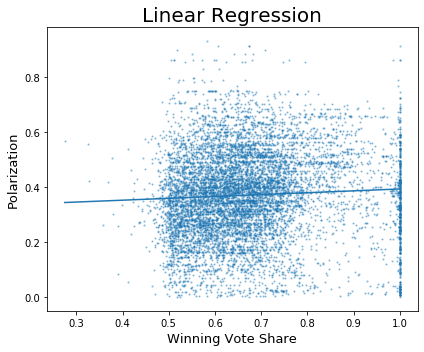

In [248]:
fig, ax = plt.subplots(figsize = (6, 5))

model_data.plot.scatter(x = "WinShare", y = "polarized",  alpha=0.35, s=1.5, ax=ax) # Create scatterplot

# Plot the regression
x = np.array([model_data["WinShare"].min(), model_data["WinShare"].max()])
ax.plot(x, beta_0 + beta_1*x)

ax.set_title("Linear Regression", fontsize = 20)
ax.set_ylabel("Polarization", fontsize = 13)
ax.set_xlabel("Winning Vote Share", fontsize = 13)
fig.tight_layout()

***Overall, there seems to be no significant correlation between electoral competition and political polarization.***

## 4.) Geographic Distribution of Political Ideology

Next, I map the measures of polarization and electoral competition using the congressional district shapefiles

In [242]:
def plot_map_continental(yr, ax, cmap = "Reds", var = "polarized", df = datamap, 
                         vmin = 0, vmax = 1, orientation = "vertical"):
    '''
    Produces a cloropleth map in US congressional
    districts for a given year
    '''
    cont = ~(df["state"].isin(["Alaska","Hawaii"]))
    gdf = df[cont].loc[df["year"] == yr]
    plot = gdf.plot(ax = ax, edgecolor = "black", cmap = cmap, 
                    column = var, vmin = vmin, vmax = vmax, 
                     legend=True, legend_kwds = 
                    {'label': var.capitalize(),
                    'orientation': orientation})
    return plot

In the following cell, I map polarization for the beginning and end years of my dataset (1976 and 2016) to highlight the change over time. Darker values denote higher levels of polarization

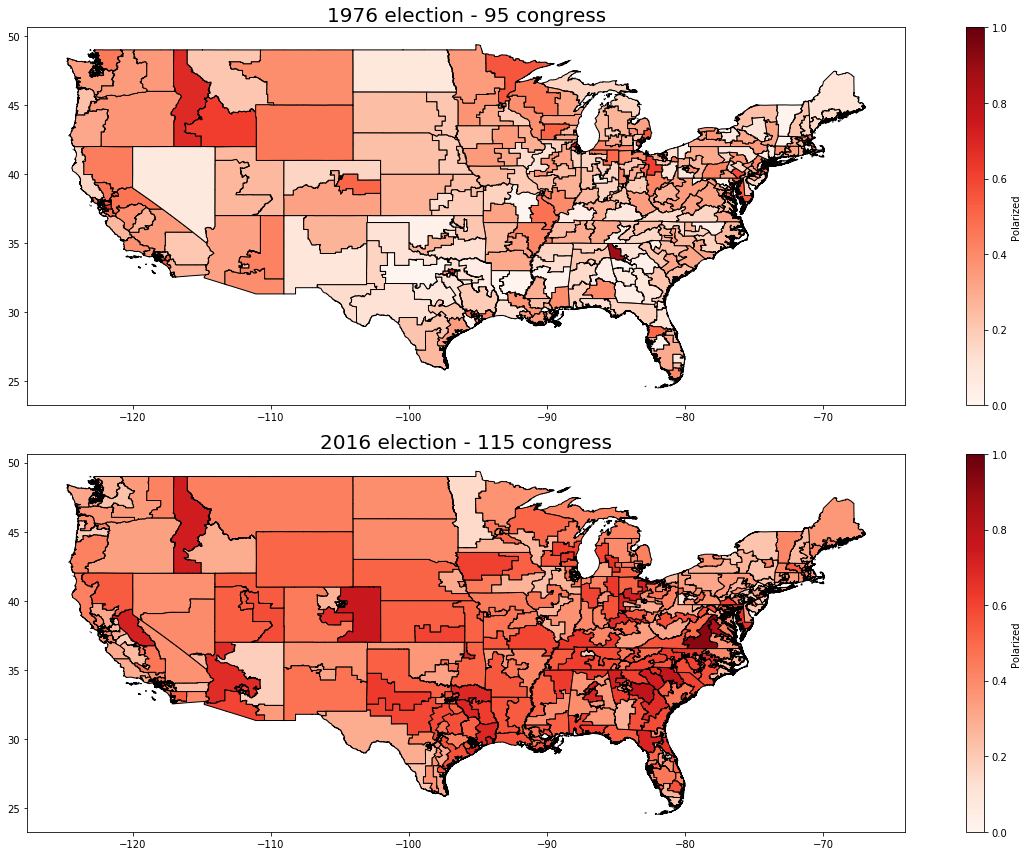

In [250]:
fig, gax = plt.subplots(2, 1, figsize = (17,12))

plot_map_continental(years[0], gax[0]) # Plot first year in dataset
plot_map_continental(years[-1], gax[1]) # Plot last year in dataset

gax[0].set_title(f"{years[0]} election - {congress[0]} congress", fontsize = 20)
gax[1].set_title(f"{years[-1]} election - {congress[-1]} congress", fontsize = 20)

fig.tight_layout()

While many of the districts become darker over the 40 year period, the most drastic change occurs in the South.


Next, I map the winning vote share for the years with the largest shock - 1988 and 1992. Darker values indicate a higher winning vote share and lower electoral competition

C:\Users\jctol\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


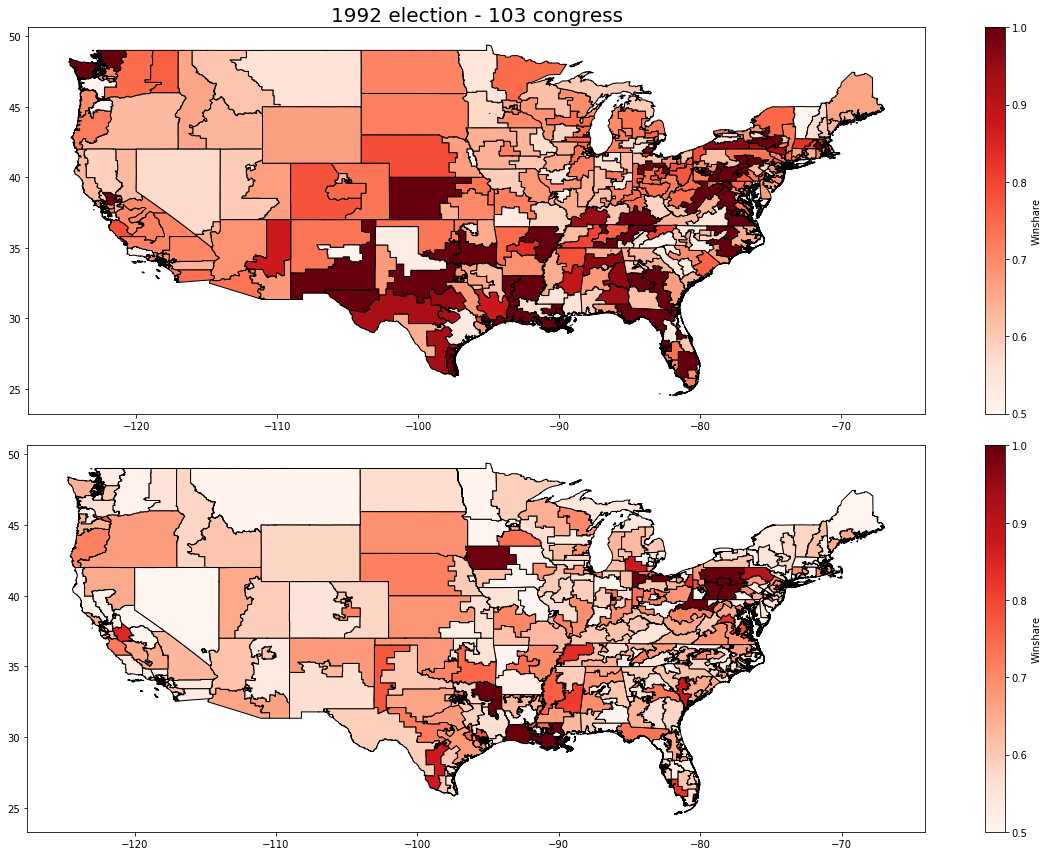

In [251]:
fig, gax = plt.subplots(2, 1, figsize = (17,12))

plot_map_continental(1988, gax[0], 'Reds', var = "WinShare", vmin = 0.5, vmax = 1)
plot_map_continental(1992, gax[1], 'Reds', var = "WinShare", vmin = 0.5, vmax = 1)

gax[0].set_title("1988 election - 101 congress" , fontsize = 20)
gax[0].set_title("1992 election - 103 congress" , fontsize = 20)

fig.tight_layout()

Consistent with the line plots, while the entire country experiences a shock to electoral competition, the South and Northeast experience the largest shocks.

## 5.) Interactive Ideology Maps

The following code uses bokeh to generate interactive maps of this data. Because of the many complex district shapes (thanks to gerrymandering), loading a map of the whole United States would take an extremely large amount of processing power. Although that would definately be interesting and useful, I specify state maps.

In [245]:
# These functions facilitate the creation of interactive maps

def statemap_json(geog_val, yr, geog = "state", df = datamap):
    '''
    Restricts dataset to given state and year, and returns
    a GeoJSONDataSource for mapping. Note: specifying the 
    level of geography (geog) can map wider regions, but
    this can take a VERY long time.
    '''
    gdf_geog = df.loc[(df[geog] == geog_val) & (df["year"] == yr)]
    json_loads = json.loads(gdf_geog.to_json())
    json_data = json.dumps(json_loads)
    geosource = GeoJSONDataSource(geojson = json_data)
    
    return geosource

def interactive_map(geog_val, yr, geog = "state", df = datamap, 
                    var = "nominate", colors = 'RdBu', low = -1, high = 1):
    '''
    Creates an interactive map with hover, zoom, and panning
    tools for given level of geography and the year. Default
    feature mapped is the NOMINATE score.
    '''
    
    geosource = statemap_json(geog_val, yr, geog, df) # Create GeoJSONDataSource
    
    # Specify colors
    palette = brewer['RdBu'][10]
    color_mapper = LinearColorMapper(palette = palette, low = -1, high = 1)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff = 8, width = 500, height = 20,
                         border_line_color = None, location = (0, 0), orientation = 'horizontal')
    
    # Specify HoverTool
    hover = HoverTool(tooltips = [ ('State','@state'), ("District",'@district'), 
                               ("NOMINATE",'@nominate'), ("Win Share",'@WinShare')])
    
    # Create figure with tools
    p = figure(title = 'NOMINATE MAP', plot_height = 700 , plot_width = 700, 
               toolbar_location = "right", tools=[hover, WheelZoomTool(), PanTool(),
                                                  BoxZoomTool(), ResetTool()])
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.patches('xs','ys', source = geosource, fill_color = {'field' : var, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)
    p.add_layout(color_bar, 'below')
    
    # Show output in the notebook
    output_notebook()

    return show(p)

#### Make Your Own Map!

Adapt the next cell to create an interactive map for the state and election year of your chooing. Enter your preferred parameters into `custom_state` and `custom_year`. Hover over a district to reveal the NOMINATE score and WinShare. Click the tools on the right of the figure to toggle between them. 

Naturally, blue indicates liberal districts and red indicates conservative districts

In [246]:
custom_state = "Ohio" # Any U.S. State except for Alaska
custom_year = 2000 # Any even numbered year between 1976 and 2016


# This function generates the map
interactive_map("Ohio", 2000)

Loading BokehJS ...

# 6.) Conclusion

In this analysis I find that while the United States has been experiencing an upward trend in political polarization, this cannot be explained by decreased electoral competition. However, it could be the case that ommited variables are driving apparent the lack of a relationship between competition and polarization. In any case, victory margins in congressional elections have become smaller over time (though highly volatile in the process), leading to a slow rise in electoral competition.

I do however find that the increase in polarization is largely driven by dynamics playing out in the South. I also find a temporary but sharp increase in electoral competition in the 90s. These findings provide a starting point for a more in depth analysis.

Finally, the maps I've created provide a highly interactive way of comparing the political ideologies of congressional districts. (Note: I tried very hard to get a year slider to work, but in the end it required writing a callback funtion in Javascript which sadly I was not equipped to do)

## References

Alesina, Alberto. 1988. "Credibility and Policy Convergence in a Two-Party System with Rational Voters." The American Economic Review 78 (4): 796-805.

Downs, Anthony. 1957. "An Economic Theory of Political Action in a Democracy." Journal of 
Political Economy 65 (2): 135-150.
